In [161]:
%matplotlib inline
import sys, os, glob, copy

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

import scienceplots

plt.style.use(['bright', 'science', 'no-latex','notebook'])

In [230]:
data_agn_updated = ascii.read('hsc_agn_updated.txt')
data_agn_compare = ascii.read('hsc_agn_compare.txt')
data_agn = ascii.read('hsc_agn.txt')

plot the table in a skymap

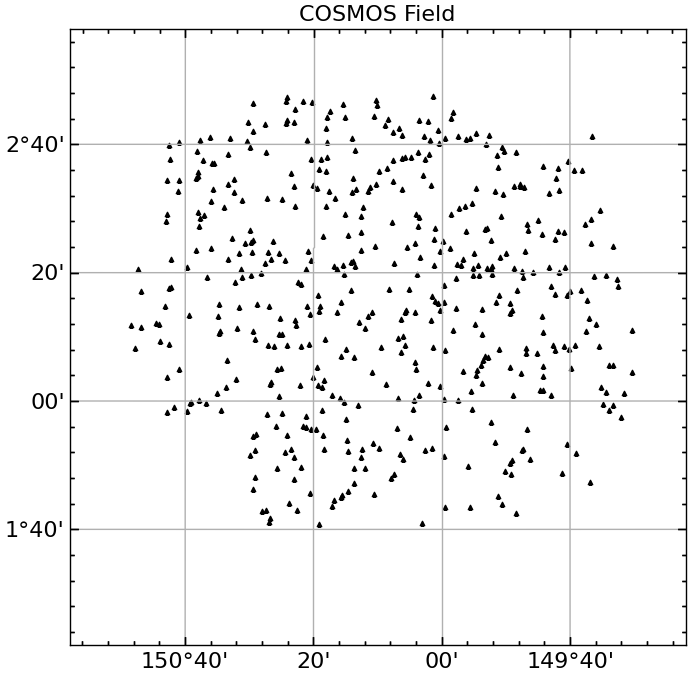

In [163]:
import ligo.skymap.plot

ra, dec = data_agn_updated['RAdeg'], data_agn_updated['DEdeg']

fig = plt.figure(figsize=[12, 8], dpi=100)
ax1 = plt.axes(projection='astro degrees zoom', center='150d10m 2d10m', radius='0.8 deg')

ax1.scatter(ra, dec, transform=ax1.get_transform('world'), s=10, marker='^', color='k', alpha=1, label='DES')

ax1.grid()
# ax1.coords['ra'].set_ticks_v
# ax1.coords['dec'].set_ticks_v
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)

ax1.set_title('COSMOS Field')

plt.show()

In [164]:
result_rvz_bib = data_agn_updated['bibcode']
bib, cnt = np.unique(result_rvz_bib, return_counts=True)
table.Table([bib, cnt], names=['bibcode','count'])

bibcode,count
str19,int64
-------------------,129
2009ApJ...696.1195T,17
2015ApJS..220...12S,1
2018ApJ...858...77H,22
2018ApJ...869...20B,2
2018ApJS..234...21D,1
2018PASJ...70S..10O,1
2020AJ....160...37M,1
2020ApJ...894...24K,316


### Dataset overview

The spectra come from the following sources

```
------------------- 99
2009ApJ...696.1195T 23, Magellean/zCOSMOS, https://irsa.ipac.caltech.edu/data/COSMOS/
2015ApJS..220...12S 3
2018ApJ...858...77H 40, DEIMOS, not publicly available
2018ApJ...869...20B 2
2018ApJS..234...21D 1
2018ApJS..239...27S 3
2018PASJ...70S..10O 1
2019ApJ...877...81M 1
2020AJ....160...37M 1
2020ApJ...894...24K 316, HSC, a collection of specz but its sources may be available
2021ApJS..256....9S 1
```

where HSC data is compiled from the following sources: 

```
2013ApJ...767..118C, PRIMUS, only z-value is presented
```

Note: 

* "`-------------------`" means photo-z
* `2020ApJ...894...24K` and `2018ApJ...858...77H` refers to original catalogs


In [165]:
# Charlotte has already done SDSS - nice!

# Will add the other ones (XMM-spec, Caltech COSMOS Magellen etc,)

## Magellean (incomplete)

inquiry website: https://irsa.ipac.caltech.edu/data/COSMOS/

ValueError: Cannot parse first argument data "10:02:17.502:23:15.1" for attribute ra

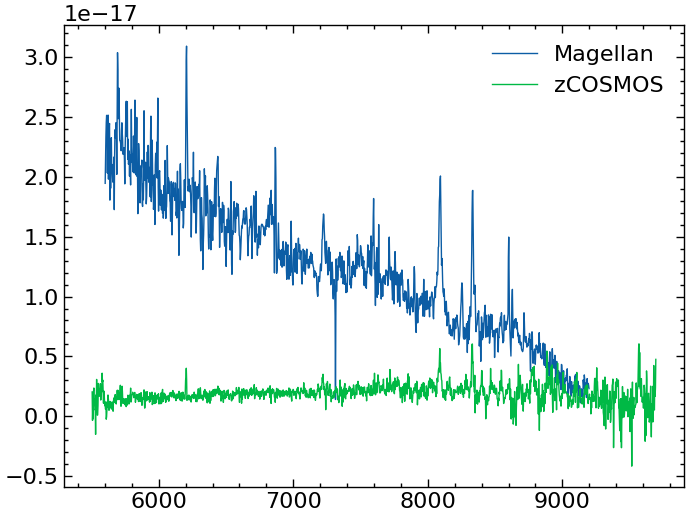

In [166]:
# SDSS J100252.84+021452.8 

hdu1 = fits.open('spec/magellan_opt_100252+021452_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

hdu2 = fits.open('spec/zCOSMOS_BRIGHT_DR3_000821837_ZCMRa95_M1_Q2_16_1.fits')
data2 = hdu2[1].data
plt.plot(data2['WAVE'][0], data2['FLUX_REDUCED'][0], label='zCOSMOS', linewidth=1)

plt.legend()

hdu1[0].header['DATE-OBS'], hdu2[0].header['DATE-OBS']

SkyCoord(hdu1[0].header['RA']+''+hdu1[0].header['DEC'], unit=(u.hourangle, u.deg)), \
SkyCoord(str(hdu2[0].header['RA'])+''+str(hdu2[0].header['DEC']), unit=(u.deg, u.deg)), \
SkyCoord('10:02:52.84 +02:14:52.8', unit=(u.hourangle, u.deg)), 

(<SkyCoord (ICRS): (ra, dec) in deg
     (150.22791667, 1.67563889)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.612274, 1.99442)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.61225, 1.99447222)>)

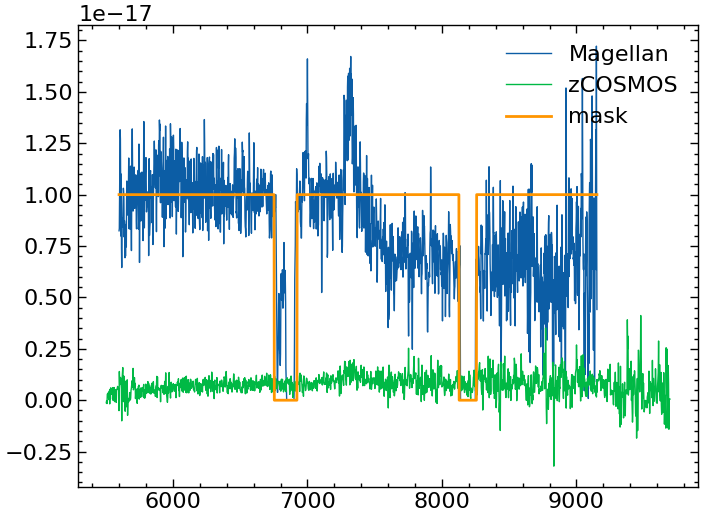

In [ ]:
# ACS-GC 20054857

hdu1 = fits.open('spec/magellan_opt_100226+015940_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

hdu2 = fits.open('spec/zCOSMOS_BRIGHT_DR3_000815962_ZCMRa83_M2_Q2_22_1.fits')
data2 = hdu2[1].data
plt.plot(data2['WAVE'][0], data2['FLUX_REDUCED'][0], label='zCOSMOS', linewidth=1)


plt.plot(data1[0], data1[3]*1e-17, label='mask')

plt.legend()

hdu1[0].header['DATE-OBS'], hdu2[0].header['DATE-OBS']

SkyCoord(hdu1[0].header['RA']+''+hdu1[0].header['DEC'], unit=(u.hourangle, u.deg)), \
SkyCoord(str(hdu2[0].header['RA'])+''+str(hdu2[0].header['DEC']), unit=(u.deg, u.deg)), \
SkyCoord('10h 02m 26.94s +01d 59m 40.1s')
# SkyCoord('10:02:52.84 +02:14:52.8', unit=(u.hourangle, u.deg)), 



template spectra: https://classic.sdss.org/dr5/algorithms/spectemplates/

HDU description: https://classic.sdss.org/dr5/dm/flatFiles/spSpec.html 

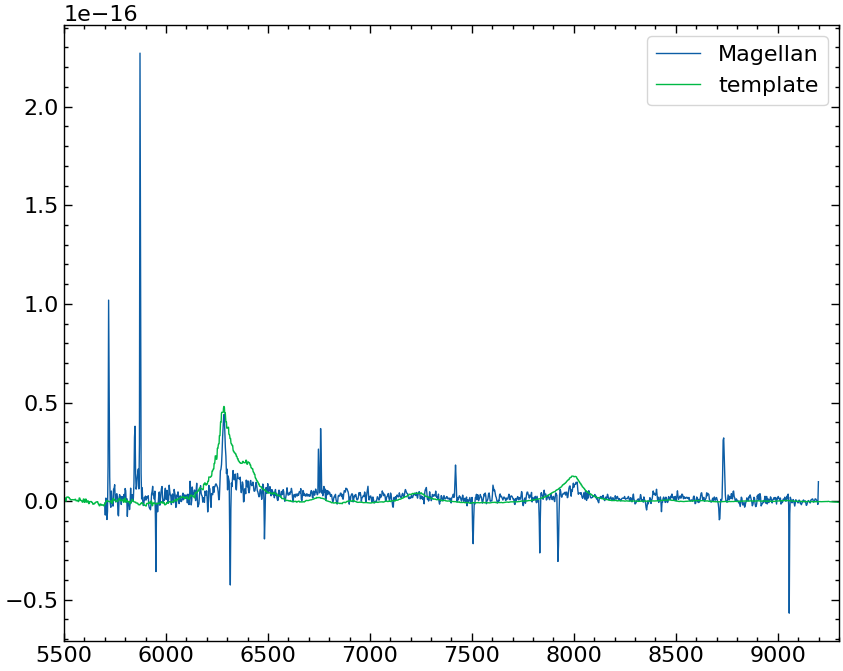

In [ ]:
# COSMOS 2042408 (300)

plt.figure(figsize=[10, 8])

hdu1 = fits.open('spec/magellan_opt_095906+022639_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

wl_HB = 4861
wl_MgII = 2798
wl_CIV = 1549
# z = 0.276
# plt.axvline(x=wl_HB*(1+z), c='C1', linewidth=1, label='H Beta (HSC z)')
z = 4.17
# plt.axvline(x=wl_CIV*(1+z), c='C2', linewidth=1, label='C IV (Magellan z)')

hdutemp = fits.open('spec/spDR2-029.fit')
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
plt.plot(np.logspace(start, stop, num)*(1+z), datatemp[1]*1e-17/5, label='template', linewidth=1)

plt.xlim(5500, 9300)
plt.legend(frameon=True)


In [ ]:
# COSMOS2015 382203 (52)



## HSC (incomplete)

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

inquiry website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/specz-2/

### Grab the HSC data and see what database it comes from

We first download all the spectra in cosmos field and then filter them using python. HSC catalog uses `SQL` to inquire about the redshift, which is not suitable for mass and fuzzy inquiry. 

```sql

SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift
      , specz_duplicationflag

      , specz_flag_zcosmos_bright_dr3
      , specz_flag_3dhst_v4_1_5
      , specz_flag_sdss_dr15
      , specz_flag_gama_dr3
      , specz_flag_udsz_dr1
      , specz_flag_vandels_dr2
      , specz_flag_c3r2_dr2
      , specz_flag_vvds_drfinal
      , specz_flag_deimos_2018
      , specz_flag_fmos_dr2
      , specz_flag_lega_c_dr2
      , specz_flag_primus_dr1
      , specz_flag_vipers_dr2
      , specz_flag_wigglez_dr1
      , specz_flag_deep23_dr4_egs

    FROM pdr3_dud_rev.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;

```

It will return a `csv` file that contains all the phot-z in COSMIS field. 

Then, we match our catalog to csv that contains its source. 

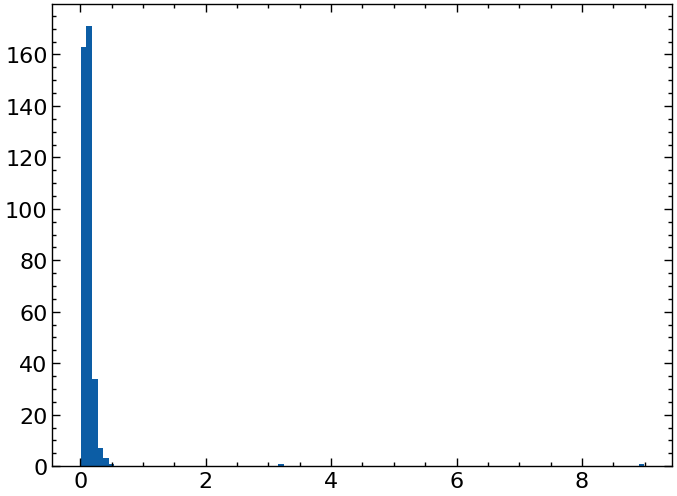

In [236]:
data_hsc_mask = data_agn_updated['r_z'] == 1
data_coords = SkyCoord(data_agn_updated['RAdeg'], data_agn_updated['DEdeg'], unit=[u.deg, u.deg])

source_keys = ['specz_flag_zcosmos_bright_dr3', 'specz_flag_3dhst_v4_1_5', 'specz_flag_sdss_dr15', 'specz_flag_gama_dr3', 'specz_flag_udsz_dr1', 'specz_flag_vandels_dr2', 'specz_flag_c3r2_dr2', 'specz_flag_vvds_drfinal', 'specz_flag_deimos_2018', 'specz_flag_fmos_dr2', 'specz_flag_lega_c_dr2', 'specz_flag_primus_dr1', 'specz_flag_vipers_dr2', 'specz_flag_wigglez_dr1', 'specz_flag_deep23_dr4_egs']
hsc_targets = ascii.read('spec/420753.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])
hsc_duplication_mask = hsc_targets['specz_duplicationflag']==10

idx, d2d, _ = data_coords[data_hsc_mask].match_to_catalog_sky(hsc_coords)

plt.hist(d2d.to(u.arcsec).value, bins=100);

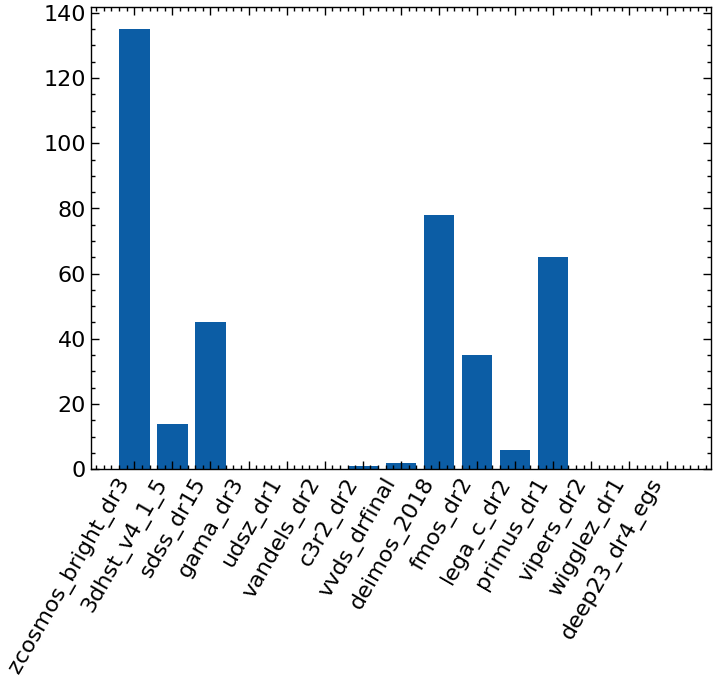

In [237]:
hsc_sources = {}
for key in source_keys: 
    hsc_sources[key] = np.count_nonzero(hsc_targets[idx][key])

plt.bar([key[11:] for key in hsc_sources.keys()], hsc_sources.values())
plt.xticks(rotation=60, ha='right');

TODO: check all the sources in HSC and download them

```
specz_flag_zcosmos_bright_dr3
specz_flag_3dhst_v4_1_5
specz_flag_sdss_dr15 
specz_flag_deimos_2018
specz_flag_fmos_dr2
specz_flag_primus_dr1
```


### Solve the inconsistent redshifts

Now, we can check which catalog the inconsistent data comes from. 

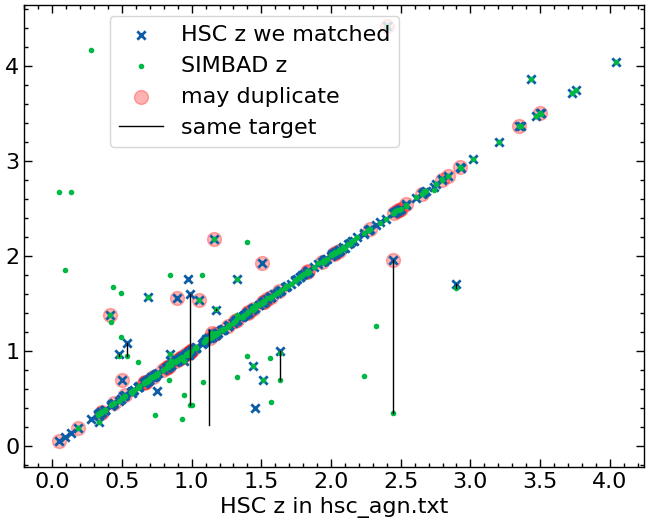

In [238]:
compare_mask = data_agn_compare[data_hsc_mask]['HSC-z']!=0
duplication_mask = hsc_targets[idx]['specz_duplicationflag']!=100
match_mask = d2d<1*u.arcsec

plt.scatter(data_agn_compare[data_hsc_mask]['HSC-z'][match_mask & compare_mask], 
            hsc_targets[idx]['specz_redshift'][match_mask & compare_mask], 
            marker='x', label='HSC z we matched')
plt.scatter(data_agn_compare[data_hsc_mask]['HSC-z'][match_mask & compare_mask], 
            data_agn_compare[data_hsc_mask]['SIMBAD-z'][match_mask & compare_mask], 
            marker='.', label='SIMBAD z')

# duplication flag
plt.scatter(data_agn_compare[data_hsc_mask]['HSC-z'][match_mask & duplication_mask & compare_mask], 
            hsc_targets[idx]['specz_redshift'][match_mask & duplication_mask & compare_mask], 
            marker='o', label='may duplicate', alpha=0.3, zorder=0, c='r', s=100)

# check if we actually have 3 different values
x = data_agn_compare[data_hsc_mask]['HSC-z']
y1 = hsc_targets[idx]['specz_redshift']
y2 = data_agn_compare[data_hsc_mask]['SIMBAD-z']
for i in range(len(data_agn_compare[data_hsc_mask])): 
    if abs(x[i]-y1[i])>0.1 and abs(x[i]-y2[i])>0.1:
        plt.plot([x[i], x[i]], [y1[i], y2[i]], color='k', linewidth=1)
plt.plot(0, 0, color='k', linewidth=1, label='same target')

plt.xlabel('HSC z in hsc_agn.txt')
plt.ylabel('')
plt.legend(frameon=True, loc='upper left',  bbox_to_anchor=(0.12, 1));

1. Overlapping `.` and `x` but not in $y=x$ indicates that HSC z actually gives the same result as SIMBAD, which means that the HSC-z in `hsc_agn.txt` gives a wrong result than DR3. 

2. Single `.` means that HSC is indeed different from SIMBAD, and maybe `HSC` is wrong. We need to further examine where these dots fome from. 

3. Single `x` means that the data we matched and the data in `hsc_agn.txt` are different, but `hsc_agn.txt` gives the same result as SIMBAD. 

4. There are a few objects that has 3 values in 3 catalogs, all of which are duplicated sources. 

Ignore 0 values. These are the sources have no SIMBAD spectrum in good quality. 

"May duplicate" means that there is object(s) in HSC database within 0.5 arcsec. 

One possible reason for those off `x` (1. and 3.) is that they used L1 norm instead of cone search to match the catalog. 

#### For case 2, we check which database the inconsistent values come from. 

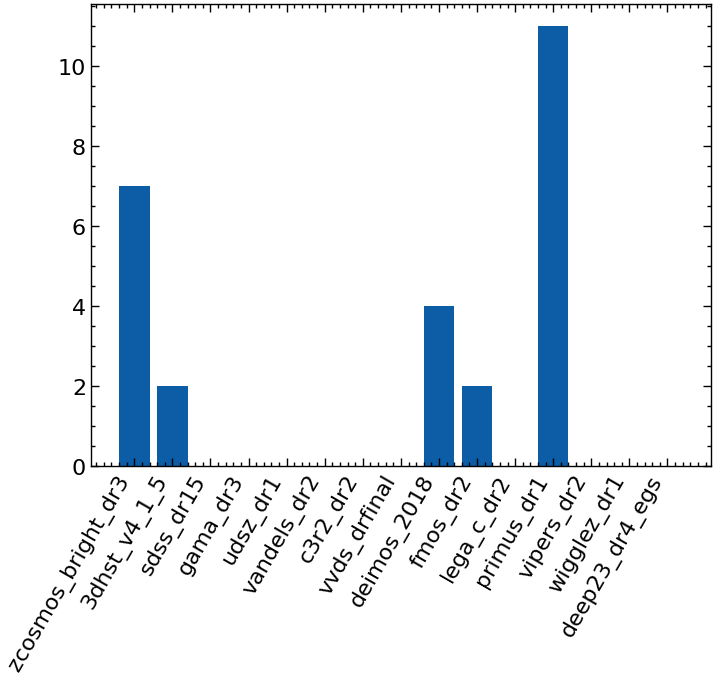

In [239]:
check_hsc_mask = (abs(data_agn_compare[data_hsc_mask]['HSC-z'] - hsc_targets[idx]['specz_redshift'])<0.05) & \
                 (abs(data_agn_compare[data_hsc_mask]['HSC-z'] - data_agn_compare[data_hsc_mask]['SIMBAD-z'])>0.05)


check_hsc_sources = {}
for key in source_keys: 
    check_hsc_sources[key] = np.count_nonzero(hsc_targets[idx][check_hsc_mask][key])

plt.bar([key[11:] for key in check_hsc_sources.keys()], check_hsc_sources.values())
plt.xticks(rotation=60, ha='right');


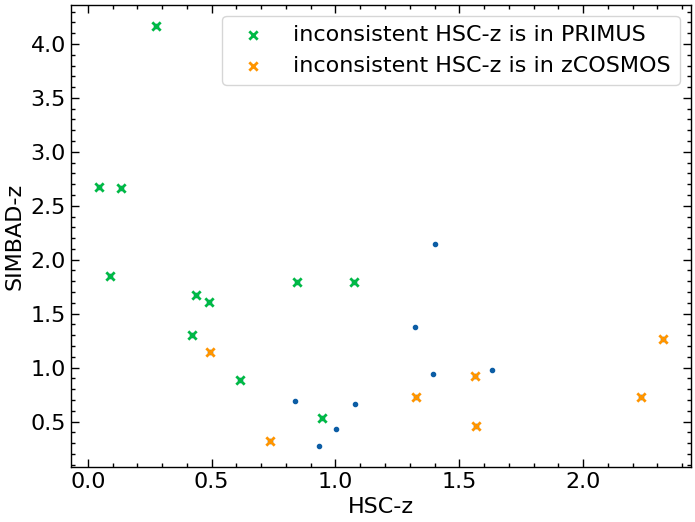

In [240]:
plt.scatter(data_agn_compare[data_hsc_mask][check_hsc_mask]['HSC-z'], 
        data_agn_compare[data_hsc_mask][check_hsc_mask]['SIMBAD-z'], 
        marker='.')
mask_primus = hsc_targets[idx][check_hsc_mask]['specz_flag_primus_dr1']==True
plt.scatter(data_agn_compare[data_hsc_mask][check_hsc_mask]['HSC-z'][mask_primus], 
        data_agn_compare[data_hsc_mask][check_hsc_mask]['SIMBAD-z'][mask_primus], 
        marker='x', label='inconsistent HSC-z is in PRIMUS')
mask_zcosmos = hsc_targets[idx][check_hsc_mask]['specz_flag_zcosmos_bright_dr3']
plt.scatter(data_agn_compare[data_hsc_mask][check_hsc_mask]['HSC-z'][mask_zcosmos], 
        data_agn_compare[data_hsc_mask][check_hsc_mask]['SIMBAD-z'][mask_zcosmos], 
        marker='x', label='inconsistent HSC-z is in zCOSMOS')
plt.xlabel('HSC-z')
plt.ylabel('SIMBAD-z')
plt.legend(frameon=True);

TODO: Check with case 1 hsc_agn.txt and 3?

### Check with PDR2

The purpose of this subsection is to check if the 

codes are copied and slightly modified from the above 2 subsections. 

```sql

SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift

    FROM pdr2_dud.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;

```


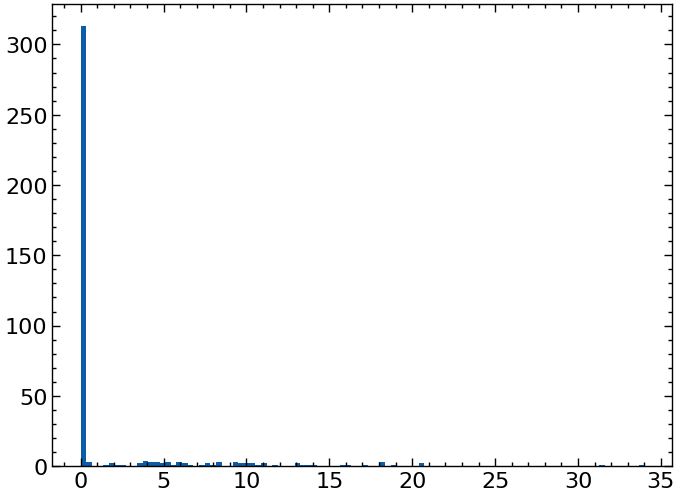

In [223]:
data_hsc_mask = data_agn_updated['r_z'] == 1
data_coords = SkyCoord(data_agn_updated['RAdeg'], data_agn_updated['DEdeg'], unit=[u.deg, u.deg])

hsc_targets = ascii.read('spec/421976.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])

idx, d2d, _ = data_coords[data_hsc_mask].match_to_catalog_sky(hsc_coords)

plt.hist(d2d.to(u.arcsec).value, bins=100);

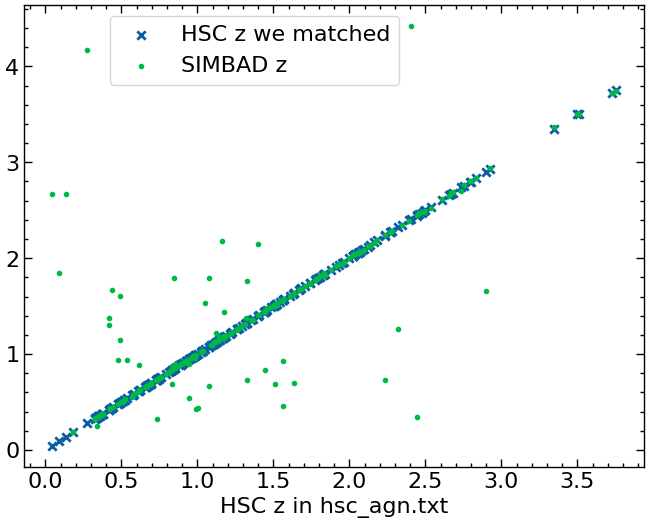

In [224]:
match_mask = d2d<1*u.arcsec
compare_mask = data_agn_compare[data_hsc_mask]['HSC-z']!=0

plt.scatter(data_agn_compare[data_hsc_mask]['HSC-z'][match_mask & compare_mask], 
            hsc_targets[idx]['specz_redshift'][match_mask & compare_mask], 
            marker='x', label='HSC z we matched')
plt.scatter(data_agn_compare[data_hsc_mask]['HSC-z'][match_mask & compare_mask], 
            data_agn_compare[data_hsc_mask]['SIMBAD-z'][match_mask & compare_mask], 
            marker='.', label='SIMBAD z')

# # check if we actually have 3 different values
# x = data_agn_compare[data_hsc_mask]['HSC-z']
# y1 = hsc_targets[idx]['specz_redshift']
# y2 = data_agn_compare[data_hsc_mask]['SIMBAD-z']
# for i in range(len(data_agn_compare[data_hsc_mask])): 
#     if abs(x[i]-y1[i])>0.1 and abs(x[i]-y2[i])>0.1:
#         plt.plot([x[i], x[i]], [y1[i], y2[i]], color='k', linewidth=1)
# plt.plot(0, 0, color='k', linewidth=1, label='same target')

plt.xlabel('HSC z in hsc_agn.txt')
plt.ylabel('')
plt.legend(frameon=True, loc='upper left',  bbox_to_anchor=(0.12, 1));

There are many targets fail to match in our inquiry, but there is no in consistency observed between DR2 and `hsc_agn.txt`. 

### Check those suspiciously aligned phot-z

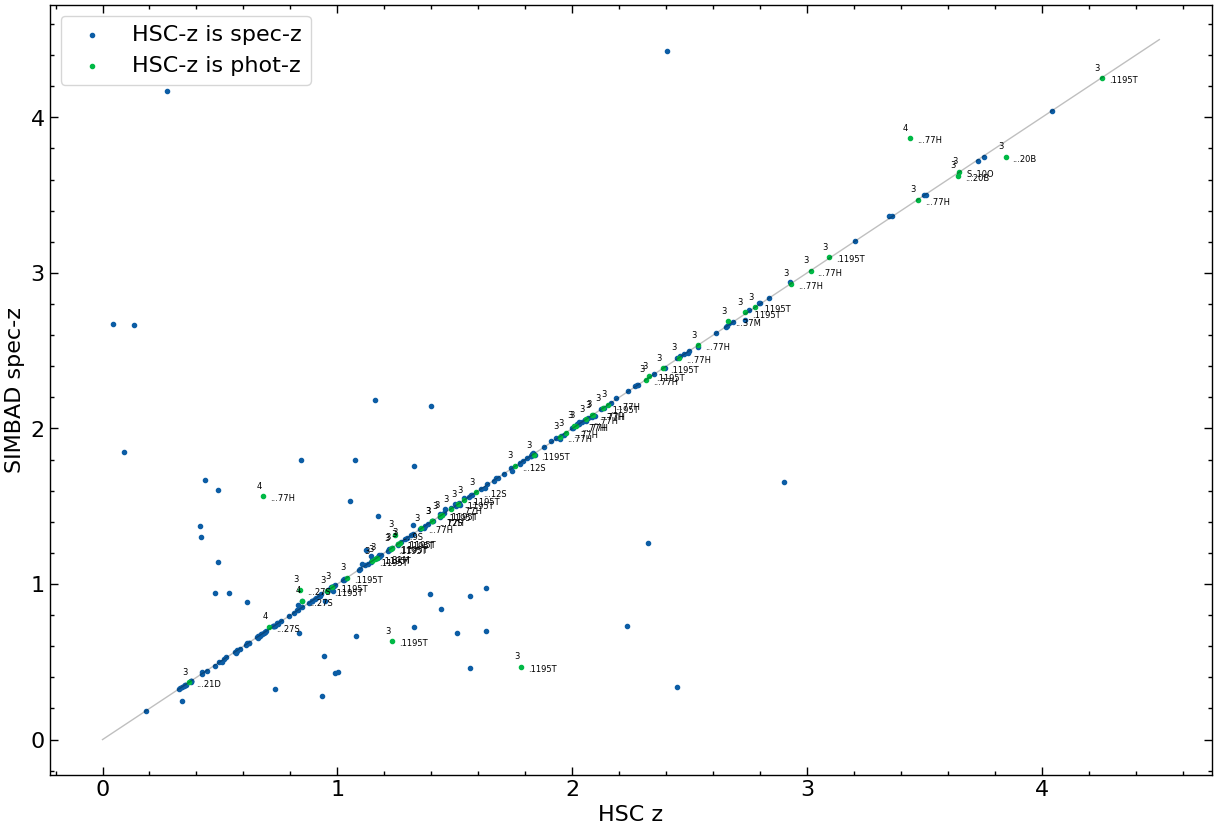

In [242]:
plt.figure(figsize=[15, 10])

plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='HSC-z is spec-z')
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='HSC-z is phot-z')
# add bibcode to interested dots
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if (data_agn_compare['r_HSC-z'][i]=='phot'): #(np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1) : 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.03), size=6)
        plt.annotate(data_agn['r_z'][i], (data_agn_compare['HSC-z'][i]-0.03, data_agn_compare['SIMBAD-z'][i]+0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()

Still, most data that has a `phot-z` label in HSC paper has a spec-z coming from zCOSMOS and DEIMOS.

In HSC paper, the `phot-z` comes form Chandra catalog (`2016ApJ...817...34M`) or COSMOS2015 catalog (`2016ApJS..224...24L`). 

For Chandra catalog, seems like 41% of its redsfhit is actually spec-z (chapter 6.1). 



# 

In [ ]:
data_agn_updated

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392,-------------------
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.499,1,592797,2020ApJ...894...24K
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.977,1,565402,2020ApJ...894...24K
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.573,1,552225,2020ApJ...894...24K
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.585,1,589540,2020ApJ...894...24K
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.664,1,625595,2020ApJ...894...24K
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964,1,689768,2020ApJ...894...24K
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.999,1,782508,2020ApJ...894...24K
9,150.71391,1.97214,22.87,1,1,1,1,1,5,1.474,3,445280,-------------------


In [215]:
data_agn_compare

HSC-z,r_HSC-z,SIMBAD-z,bib_SIMBAD-z,name
float64,str4,float64,str19,str40
0.0,none,0.0,-------------------,--
3.499,spec,3.5026,2014A&A...563A..54P,SDSS J100256.53+021158.4
0.977,spec,0.979,2009ApJ...696.1195T,SDSS J100256.04+020923.2
0.573,spec,0.5727,2018A&A...611A..53J,COSMOS2015 552225
0.585,spec,0.5824,2009ApJ...696.1195T,SDSS J100307.82+021134.9
0.664,spec,0.6652,2009ApJ...696.1195T,SDSS J100252.84+021452.8
1.964,spec,1.9555,2009ApJ...696.1195T,[VV2006] J100309.2+022038
1.999,spec,2.0051,2009ApJ...696.1195T,[VV2006] J100251.7+022905
0.0,none,0.0,-------------------,--


In [ ]:
from astropy.table import Table
Table.read('spec/420753.csv', format='csv', converters={'specz_flag_zcosmos_bright_dr3': [ascii.convert_numpy(bool)]})

# object_id,specz_ra,specz_dec,specz_redshift,specz_duplicationflag,specz_flag_zcosmos_bright_dr3,specz_flag_3dhst_v4_1_5,specz_flag_sdss_dr15,specz_flag_gama_dr3,specz_flag_udsz_dr1,specz_flag_vandels_dr2,specz_flag_c3r2_dr2,specz_flag_vvds_drfinal,specz_flag_deimos_2018,specz_flag_fmos_dr2,specz_flag_lega_c_dr2,specz_flag_primus_dr1,specz_flag_vipers_dr2,specz_flag_wigglez_dr1,specz_flag_deep23_dr4_egs
int64,float64,float64,float64,int64,bool,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5
43158734788123154,150.10261536,2.20605063,1.0276,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349173942,150.18032837,2.21132898,0.65367,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349174975,150.20129395,2.21717215,2.0717,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788127382,150.13301086,2.22695804,0.9522,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788127788,150.11584473,2.22766662,1.9218,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788135679,150.0609436,2.28366518,0.22569,10,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349178065,150.18655396,2.24057221,0.9281,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788131569,150.08352661,2.2660706,1.4717,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349182175,150.15930176,2.26882362,3.0932,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
